In [1]:
import typing
import os
import anaconfig

from Preprocessing.preprocessing import load_dataframes

from utils.plotutils.plotconfig import configure_matplotlib
from utils.commonutils.cfeatures import get_unnormalised_features

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import scipy.sparse as sps


configure_matplotlib()

In [2]:
indir = "/scratch/acorreia/data/focal-loss-nopid-shared-hits/gnn_processed/test/velo-sim10b-nospillover"

In [3]:
n_events: int = 200

array_n_connected_hits = np.zeros(shape=(n_events,), dtype=int)
array_n_intersection_hits = np.zeros(shape=(n_events,), dtype=int)
array_n_real_intersection_hits = np.zeros(shape=(n_events,), dtype=int)

for idx, filename in enumerate(tqdm(os.listdir(indir)[: n_events])):
    path = os.path.join(indir, filename)
    batch = torch.load(path, map_location="cpu")

    # Count number of particle / hit ID
    df_hits_particles = pd.read_parquet(
        batch.truncated_path + "-hits_particles.parquet",
        columns=["hit_id", "particle_id"]
    )
    hit_id_counts = df_hits_particles.groupby(
        ["hit_id"]
    )["particle_id"].count().rename("n_particles").reset_index()

    # Apply score cut
    score_cut = 0.7
    edge_indices = batch.edge_index[:, batch.scores > score_cut]
    y =  batch.y[batch.scores > score_cut]

    # Build dataframe of edges
    df_edges = pd.DataFrame(
        dict(
            idx_left=edge_indices[0].numpy(),
            idx_right=edge_indices[1].numpy(),
            plane_left=batch.plane[edge_indices[0]].numpy(),
            plane_right=batch.plane[edge_indices[1]].numpy(),
        )
    )

    # Deduce dataframe of connected nodes
    n_left = df_edges.groupby(["idx_left"])["idx_right"].count().rename("n_left")
    n_right = df_edges.groupby(["idx_right"])["idx_left"].count().rename("n_right")
    
    df_n_left = n_left.reset_index().rename(columns={"idx_left": "idx"})
    df_n_right = n_right.reset_index().rename(columns={"idx_right": "idx"})
    
    df_connected_nodes = pd.merge(
        df_n_left,
        df_n_right,
        on="idx",
        how="outer",
    ).fillna(0)

    # Deduce dataframe of intersection nodes
    df_intersection_nodes = df_connected_nodes[
        (df_connected_nodes["n_left"] >= 1) & (df_connected_nodes["n_right"] >= 1)
        & ((df_connected_nodes["n_left"] >= 2) | (df_connected_nodes["n_right"] >= 2))
    ].copy()

    # Get the information whether an intersection nodes correspond truly to
    # 2 different particles
    hit_ids = batch.hit_id.numpy()
    
    df_intersection_nodes["hit_id"] = hit_ids[df_intersection_nodes["idx"]]
    df_intersection_nodes = df_intersection_nodes.merge(
        hit_id_counts,
        on=["hit_id"],
        how="left",
    )

    # Now, count!
    array_n_connected_hits[idx] = df_connected_nodes.shape[0]
    array_n_intersection_hits[idx] = df_intersection_nodes.shape[0]
    array_n_real_intersection_hits[idx] = (df_intersection_nodes["n_particles"] >= 2).sum()
   


  0%|          | 0/200 [00:00<?, ?it/s]

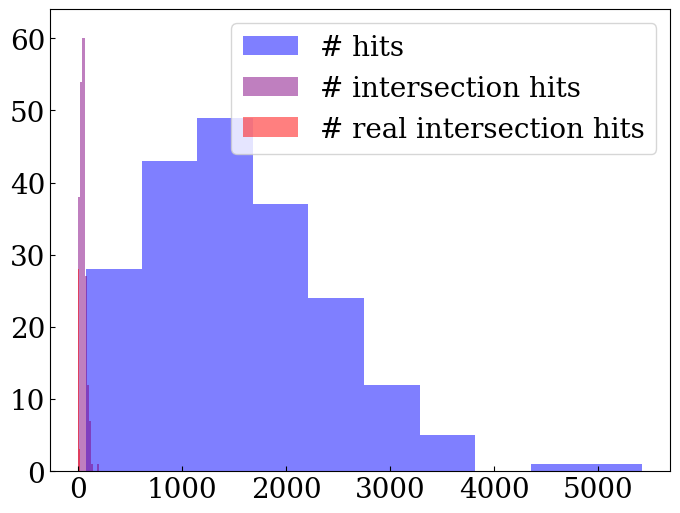

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(
    array_n_connected_hits,
    label="# hits",
    color="b",
    alpha=0.5,
)
ax.hist(
    array_n_intersection_hits,
    label="# intersection hits",
    color="purple",
    alpha=0.5,
)
ax.hist(
    array_n_real_intersection_hits,
    label="# real intersection hits",
    color="red",
    alpha=0.5,
)
ax.legend()


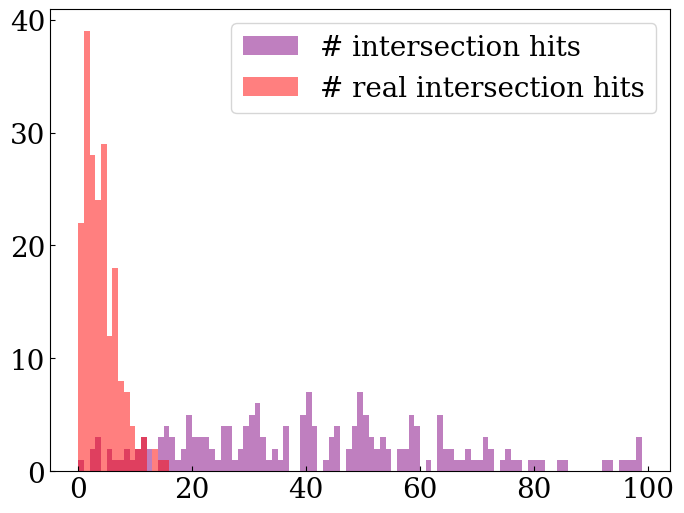

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
_, edges, _ = ax.hist(
    array_n_intersection_hits,
    label="# intersection hits",
    color="purple",
    alpha=0.5,
    bins=np.arange(100),
)
ax.hist(
    array_n_real_intersection_hits,
    label="# real intersection hits",
    color="red",
    alpha=0.5,
    bins=edges,
)
ax.legend()

In [6]:
print(array_n_real_intersection_hits.mean())
print(array_n_real_intersection_hits.std())


3.535
2.971325461809931


In [7]:
print(array_n_real_intersection_hits.max())
print(array_n_real_intersection_hits.min())


15
0


In [8]:
print(array_n_intersection_hits.mean())
print(array_n_intersection_hits.std())


44.97
28.600858378727025


In [9]:
print((array_n_real_intersection_hits / array_n_connected_hits).mean())
print((array_n_real_intersection_hits / array_n_connected_hits).std())


0.002132980312493509
0.0013265012649631388


In [10]:
print((array_n_intersection_hits / array_n_connected_hits).mean())
print((array_n_intersection_hits / array_n_connected_hits).std())


0.028153974777352243
0.006694641608911652
